In [45]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import get_all_test_pairs_path, get_all_train_pairs_path

In [48]:
# CAR_PICTURE_DIR = "../TestDataset/"
# pairs = get_all_test_pairs_path(CAR_PICTURE_DIR)
CAR_PICTURE_DIR = "../TrainDatasets/v0/"
pairs = get_all_train_pairs_path(CAR_PICTURE_DIR)

Min value in mask: 0.0
Max value in mask: 1.0


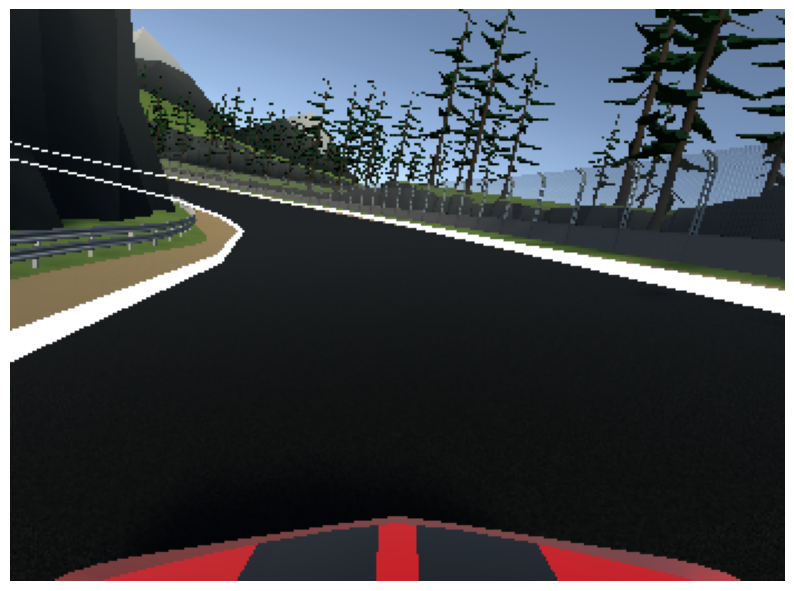

In [49]:
pair = random.choice(pairs)

original_image = Image.open(pair[0]).convert("RGB")
original_image = np.array(original_image)

original_mask = Image.open(pair[1]).convert("L")
original_mask = np.array(original_mask)
original_mask = (original_mask > 127).astype(np.float32)
print(f"Min value in mask: {np.min(original_mask)}")
print(f"Max value in mask: {np.max(original_mask)}")

fig = plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.axis('off')
plt.show()

Original image shape: (256, 347, 3)
Transformed image shape: torch.Size([3, 256, 352])


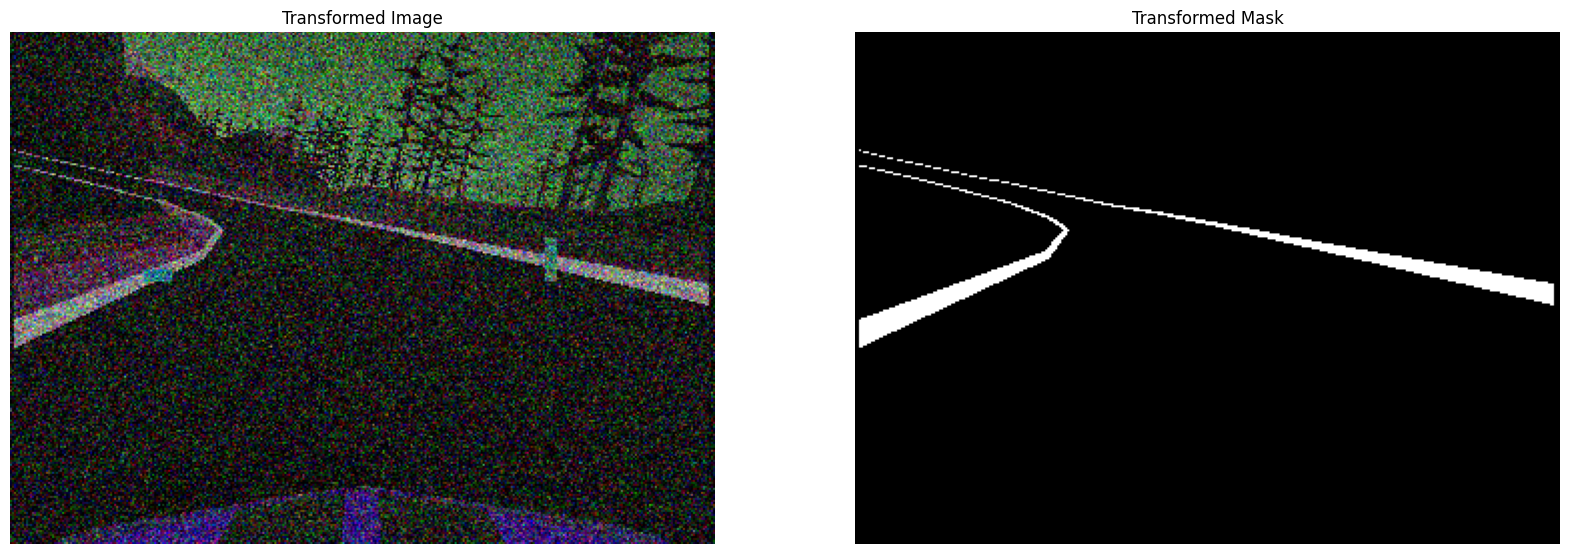

In [176]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

blur_transforms = A.OneOf([
    A.GaussianBlur(blur_limit=(3, 7), p=0.4),
    A.MedianBlur(blur_limit=5, p=0.2),
    A.MotionBlur(blur_limit=(3, 7), p=0.4),
], p=0.3)

noise_transforms = A.OneOf([
    A.GaussNoise(std_range=(0.1, 0.2), p=0.25),
    A.ISONoise(color_shift=(0.01, 0.5), intensity=(0.1, 0.5), p=0.3),
    A.MultiplicativeNoise(multiplier=(0.7, 1.5), elementwise=True, p=0.2),
    A.SaltAndPepper(amount=(0.02, 0.1), p=0.25),
], p=0.3)

constrained_dropout = A.OneOf([
    A.ConstrainedCoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.2, 0.7), hole_width_range=(0.2, 0.7), fill="random", mask_indices=[1.0], p=0.33),
    A.ConstrainedCoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.2, 0.7), hole_width_range=(0.2, 0.7), fill=0, mask_indices=[1.0], p=0.33),
    A.ConstrainedCoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.2, 0.7), hole_width_range=(0.2, 0.7), fill="random_uniform", mask_indices=[1.0], p=0.33),
], p=0.5)

grid_dropout = A.OneOf([
    A.GridDropout(unit_size_range=(20, 50), fill=0, p=0.33),
    A.GridDropout(unit_size_range=(20, 50), fill="random_uniform", p=0.33),
], p=0.5)

dropout_transforms = A.OneOf([
    constrained_dropout,
    grid_dropout,
], p=0.3)

geom_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        rotate=(-10, 10),     # petites rotations
        translate_percent=(-0.05, 0.05),  # petits déplacements
        scale=(0.9, 1.1),     # zoom léger
        shear=(-5, 5),        # léger cisaillement
        p=0.4
    ),
    A.Perspective(scale=(0.02, 0.05), p=0.3),
], p=0.7)

channel_droupout = A.OneOf([
    A.ChannelDropout(channel_drop_range=(1, 2), fill=0, p=0.5),
    A.ChannelDropout(channel_drop_range=(1, 1), fill=200, p=0.5),
], p=0.5)

color_invariance_transforms = A.OneOf([
    A.ToGray(p=0.5),
    channel_droupout
], p=0.2)

color_variation_transforms = A.OneOf([
    A.RandomBrightnessContrast(brightness_limit=0.6, contrast_limit=0.3, p=1.0),
    A.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.2, hue=0.3, p=1.0),
    A.HueSaturationValue(hue_shift_limit=100, sat_shift_limit=125, val_shift_limit=100, p=1.0),
], p=0.7)

weather_transforms = A.OneOf([
    A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), num_flare_circles_range=(6, 7), src_radius=400, method="physics_based", p=0.40),
    A.RandomShadow(shadow_roi=(0, 0.3, 1, 1), num_shadows_limit=(1, 2), shadow_intensity_range=(0.5, 0.8), p=0.20),
    A.RandomRain(slant_range=(-10, 10), drop_length=50, drop_width=1, rain_type="default", p=0.20),
    A.RandomSnow(brightness_coeff=2.5, snow_point_range=(0.1, 0.3), p=0.20)
], p=0.3)

named_transforms = {
    "blur": blur_transforms,
    "noise": noise_transforms,
    "dropout": dropout_transforms,
    "geometry": geom_transforms,
    "color_invariance": color_invariance_transforms,
    "color_variation": color_variation_transforms,
    "weather": weather_transforms,
}
from albumentations.core.transforms_interface import DualTransform
import cv2

class ResizeWithAspectRatio(DualTransform):
    def __init__(self, height, interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST, p=1.0):
        super().__init__(p=p)
        self.height = height
        self.interpolation = interpolation
        self.mask_interpolation = mask_interpolation

    def get_params_dependent_on_data(self, params, data):
        # Récupère les dimensions de l'image
        height, width = data['image'].shape[:2]

        # Calcul de la nouvelle largeur en respectant le ratio d'aspect
        new_width = int(self.height * width / height)

        # Retourne la nouvelle largeur et la hauteur fixe
        return {
            "new_width": new_width,
            "height": self.height,
            "width": width
        }

    def apply(self, img: np.ndarray, new_width: int, height: int, width: int, **params):
        # Redimensionne l'image avec la nouvelle largeur et hauteur fixe
        return cv2.resize(img, (new_width, height), interpolation=self.interpolation)

    def apply_to_mask(self, mask: np.ndarray, new_width: int, height: int, width: int, **params):
        # Redimensionne le masque avec la nouvelle largeur et hauteur fixe
        return cv2.resize(mask, (new_width, height), interpolation=self.mask_interpolation)

def build_transform(augmentation_names, image_size=(256, 256)):
    div = 2 ** 4
    return A.Compose([
        ResizeWithAspectRatio(image_size[0], interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST, p=1.0),
        A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=div, pad_width_divisor=div),
        # A.RandomCrop(256, 256),
        *[named_transforms[name] for name in augmentation_names],
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0),
        ToTensorV2(),
    ])

transform = build_transform(["geometry", "dropout", "color_invariance", "color_variation", "blur", "noise", "weather"])

def denormalize_image(tensor, mean, std):
    """
    Inverse une normalisation standard sur un tensor CxHxW
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

print(f"Original image shape: {original_image.shape}")
# Apply the transformations to the image
transformed = transform(image=original_image, mask=original_mask)
transformed_image = transformed["image"]
transformed_mask = transformed["mask"]

print(f"Transformed image shape: {transformed_image.shape}")

denormalized_image = denormalize_image(transformed_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(denormalized_image.permute(1, 2, 0).numpy())
axes[0].axis('off')
axes[0].set_title("Transformed Image")

axes[1].imshow(transformed_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Transformed Mask")
plt.show()